In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
sentiment = pd.read_csv("fear_greed_index.csv")


trades = pd.read_csv(
    "historical_data.csv",
    engine="python",
    on_bad_lines="skip"
)


In [57]:
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

print(sentiment.isna().sum())
print(trades.isna().sum())


Sentiment shape: (2644, 4)
Trades shape: (403810, 16)
timestamp         0
value             0
classification    0
date              0
dtype: int64
Account              0
Coin                 0
Execution Price      0
Size Tokens          2
Size USD             2
Side                 4
Timestamp IST        5
Start Position       8
Direction           10
Closed PnL          11
Transaction Hash    16
Order ID            20
Crossed             24
Fee                 25
Trade ID            33
Timestamp           35
dtype: int64


In [43]:
sentiment['date'] = pd.to_datetime(sentiment['date'])
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'])

sentiment['date'] = sentiment['date'].dt.date
trades['date'] = trades['Timestamp'].dt.date


In [44]:
numeric_cols = [
    'Closed PnL',
    'Size USD',
    'Fee',
    'Execution Price'
]

for col in numeric_cols:
    trades[col] = pd.to_numeric(trades[col], errors='coerce')

trades = trades.dropna(subset=numeric_cols)


In [45]:

trades['win'] = trades['Closed PnL'] > 0

trades['long'] = trades['Side'] == 'BUY'


In [46]:
daily_trader = (
    trades
    .groupby(['Account', 'date'])
    .agg(
        daily_pnl=('Closed PnL', 'sum'),
        win_rate=('win', 'mean'),
        num_trades=('Trade ID', 'count'),
        avg_trade_size=('Size USD', 'mean'),
        avg_fee=('Fee', 'mean'),
        long_ratio=('long', 'mean')
    )
    .reset_index()
)


In [47]:

df = daily_trader.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

df.rename(columns={'classification': 'sentiment'}, inplace=True)

df = df.dropna(subset=['sentiment'])


In [48]:
df.groupby('sentiment')[['daily_pnl', 'win_rate']].mean()


,daily_pnl,win_rate
sentiment,,


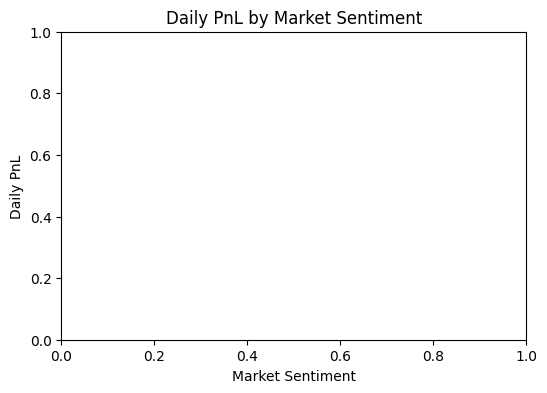

In [49]:
plt.figure(figsize=(6,4))
sns.boxplot(x='sentiment', y='daily_pnl', data=df)
plt.title("Daily PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()


In [50]:
df.groupby('sentiment')[['num_trades', 'avg_trade_size', 'long_ratio']].mean()


,num_trades,avg_trade_size,long_ratio
sentiment,,,


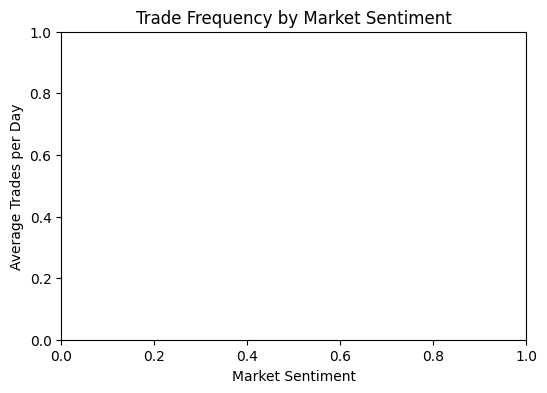

In [52]:
plt.figure(figsize=(6,4))
sns.barplot(x='sentiment', y='num_trades', data=df)
plt.title("Trade Frequency by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trades per Day")
plt.show()


In [53]:
median_trades = df['num_trades'].median()

df['activity_group'] = np.where(
    df['num_trades'] > median_trades,
    'High Activity',
    'Low Activity'
)

df['consistency'] = pd.cut(
    df['win_rate'],
    bins=[0, 0.4, 0.6, 1.0],
    labels=['Low', 'Medium', 'High']
)


In [54]:
df.groupby(['sentiment', 'activity_group'])['daily_pnl'].mean()


,,daily_pnl
sentiment,activity_group,


In [55]:
df['profit_bucket'] = np.where(df['daily_pnl'] > 0, 'Profit', 'Loss')
